In [1]:
!nvidia-smi

Wed Dec  3 21:28:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.9.0+cu126
torchvision version: 0.24.0+cu126


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 32.24 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [17]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

print(f"Train dir: {train_dir}")
print(f"Test dir: {test_dir}")

Train dir: data/pizza_steak_sushi/train
Test dir: data/pizza_steak_sushi/test


In [10]:
train_dir =image_path /"train"
test_dir =image_path /"test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [13]:
from going_modular.going_modular import data_setup
IMAGE_SIZE =224
manual_transforms = transforms.Compose([ transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),transforms.ToTensor() ])

In [19]:
from going_modular.going_modular import data_setup
from torchvision import transforms

# 1. Define the transform (Recalling the fix: Capital 'R' for Resize)
IMAGE_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

# 2. Create DataLoaders using the paths you just defined
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

# 3. Check the output
print(f"Class names: {class_names}")
print(f"Train dataloader length: {len(train_dataloader)}")
print(f"Test dataloader length: {len(test_dataloader)}")

FileNotFoundError: [Errno 2] No such file or directory: 'data/pizza_steak_sushi/train'

In [21]:
import shutil
from pathlib import Path
from going_modular.going_modular import data_setup # Import your custom module

# 1. Force delete the existing data folder to clear the error
data_path = Path("data/pizza_steak_sushi")
if data_path.exists():
    shutil.rmtree(data_path)
    print(f"Deleted corrupted directory: {data_path}")

# 2. Re-download the data (Copying the download function logic here to ensure it runs)
import requests
import zipfile

# Setup path to data folder
data_root = Path("data/")
image_path = data_root / "pizza_steak_sushi"
image_path.mkdir(parents=True, exist_ok=True)

# Download
with open(data_root / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip
with zipfile.ZipFile(data_root / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

# 3. Define paths again
train_dir = image_path / "train"
test_dir = image_path / "test"

# 4. Create DataLoaders immediately to verify it works
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # Uses the transforms we fixed earlier
    batch_size=32
)

print("\nSuccess! Data loaded.")
print(f"Classes found: {class_names}")

Deleted corrupted directory: data/pizza_steak_sushi
Unzipping pizza, steak, sushi data...

Success! Data loaded.
Classes found: ['pizza', 'steak', 'sushi']


In [23]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # Uses the transforms we fixed earlier
    batch_size=32
)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

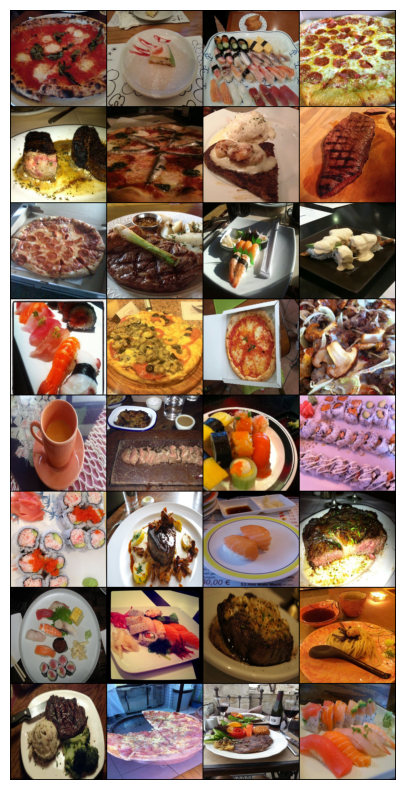

(8, 3, ['pizza', 'steak', 'sushi'])

In [25]:
#Visualize some data
import matplotlib.pyplot as plt
# Get a batch of images and labels
images, labels = next(iter(train_dataloader))
# Create a grid of images
img_grid = torchvision.utils.make_grid(images, nrow=4)
# Plot the grid
plt.figure(figsize=(10,10))
plt.imshow(img_grid.permute(1, 2, 0))  # Change from
plt.axis('off')
plt.show()  
len(train_dataloader), len(test_dataloader), class_names


In [ ]:
# Set random seeds for reproducibility
set_seeds(42)

In [ ]:
# Replicate the model architecture from the paper
